In [7]:
%pylab inline
import numpy as np
import det_sort as ds


file_name = "/Users/dwaithe/Documents/collaborators/WaitheD/micro_vision/tracking/file_pos_export.txt"

num_lines = sum(1 for line in open(file_name))
trk_mat = np.zeros((9,num_lines)).astype(np.float64)
c = 0
file = open(file_name,"r")
for line in file:
    line = line.strip('\n')
    items = line.split(",")
    #print(items)
    for i in range(0,8):
        trk_mat[i,c] = np.float(items[i])
    trk_mat[8,c] = -1
    c += 1
#print( file.readline() )
##This is how we find the neighbours.
def create_neighbour_directory(trk_mat):
    def rtn_comp(ax, alt, aht, bx, blt, bht):#, cx, clt, cht):
        return (ax > alt ) & (ax < aht)	& (bx > blt ) & (bx < bht )# & (cx > clt ) & (cx < cht )
    def rtn_hyp(ax0,ax1,bx0,bx1,xy_dist):
        return sqrt((ax0-ax1)**2 + (bx0-bx1)**2)<xy_dist
    xuni = np.unique(trk_mat[0,:])
    yuni = np.unique(trk_mat[1,:])
    zuni = np.unique(trk_mat[2,:])
    xy_dist = 101 #um
    coord = {} 

    #Populate a list of all possible coordinate neighbours within threshold.
    for xk0 in xuni:
        for yk0 in yuni:
            ent  =str(xk0)+'_'+str(yk0)

            coord[ent] = []


            for xk1 in xuni:
                for yk1 in yuni:
                    #if xk0 != xk1 or yk0 != yk1:
                        hit = rtn_comp(xk0,xk1,xk1+xy_dist//2,yk0,yk1,yk1+xy_dist+xy_dist//2)
                        #hit = rtn_hyp(xk0,xk1,yk0,yk1,xy_dist)
                        if hit == True:
                            coord[ent].append([xk1,yk1]) 

    return coord  
def return_neighbours(coord,x,y):
    return coord[str(x)+"_"+str(y)]
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep
def py_cpu_nms_overlap(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = areas.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        
        overlap = inter/areas[order[1:]]
        inds = np.where(overlap <= thresh)[0]
        order = order[inds + 1]

    return keep
def overlap(bb_test,bb_gt):
    """Computes IUO between two bboxes in the form [x1,y1,x2,y2]"""
    xx1 = np.maximum(bb_test[0], bb_gt[0])
    yy1 = np.maximum(bb_test[1], bb_gt[1])
    xx2 = np.minimum(bb_test[2], bb_gt[2])
    yy2 = np.minimum(bb_test[3], bb_gt[3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    area_test = (bb_test[2]-bb_test[0])*(bb_test[3]-bb_test[1])
    area_gt = (bb_gt[2]-bb_gt[0])*(bb_gt[3]-bb_gt[1])
    o = wh / (area_test + area_gt - wh)

    return o,(wh)/area_test,(wh)/area_gt

print('minx', np.min(trk_mat[0,:]),'maxx',np.max(trk_mat[0,:]))
print('miny', np.min(trk_mat[1,:]),'maxy',np.max(trk_mat[1,:]))
print('minz', np.min(trk_mat[2,:]),'maxz',np.max(trk_mat[2,:]))

Populating the interactive namespace from numpy and matplotlib


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


minx -9421.0 maxx -5221.0
miny 391.2 maxy 2791.2
minz 0.9927999999999999 maxz 17.992800000000003


In [270]:
np.round(trk_mat[:,0],3)

array([-7.5735e+03, -4.0880e+02,  8.4940e+00,  4.7809e+01,  3.1500e-01,
        1.7173e+01,  1.4687e+01,  1.0000e+00, -1.0000e+00])

In [8]:
#We find only save regions and exclude the rest.



#This is the unique values from an array.
x_unq = np.unique(trk_mat[0,:])
y_unq = np.unique(trk_mat[1,:])
z_unq = np.unique(trk_mat[2,:])
print(trk_mat.shape)
first_glance = []

trs = trk_mat

#for c in range(0,trs.shape[1]):
a1 = (512.*0.26 - trs[3,:]) - trs[5,:]
x1 = a1 + trs[0,:] 
b1 = trs[4,:]
y1 = b1 + trs[1,:] 

x2 = x1+(trs[5,:])
a2 = a1+(trs[5,:])
y2 = y1+(trs[6,:])
b2 = b1+(trs[6,:])

#Filter away regions near edge of image.
boolind = (a1/0.26 > 12.) & (a2/0.26 < 500.) & (b1/0.26 > 12.) & (b2/0.26 < 500.)

up = boolind
dn = (1-boolind).astype(np.bool)
trk_mat = trk_mat[:,up]
#plot([x1[up],x2[up],x2[up],x1[up],x1[up]],[y1[up],y1[up],y2[up],y2[up],y1[up]],'-', c='r', alpha=0.3)
#plot([x1[dn],x2[dn],x2[dn],x1[dn],x1[dn]],[y1[dn],y1[dn],y2[dn],y2[dn],y1[dn]],'-', c='g', alpha=0.3)
           
coord = create_neighbour_directory(trk_mat)#Find neighbouring regions.
         

in_results = []
out_results = []
for stg_x in x_unq:
    for stg_y in y_unq:
        ind = ((trk_mat[0,:] == float(stg_x)) & (trk_mat[1,:] == float(stg_y)))
        trks = trk_mat[:,ind]
        mot_tracker = []
        mot_tracker = ds.Sort(max_age=100,min_hits=0)
        
        trackers = None
        for z in z_unq:
            ind = np.where(trks[2,:] == z)[0]
            trs = trks[:,ind]

            dets = []
            for c in range(0,trs.shape[1]):
                x1 = trs[0,c] + (512.*0.26 - trs[3,c]) - trs[5,c]
                y1 = trs[1,c] + trs[4,c]
                z = trs[2,c]
                x2 = x1+(trs[5,c])
                y2 = y1+(trs[6,c])
                detstxt = np.array([x1,y1,x2,y2]).astype(np.float64)
                dets.append(detstxt)
                in_results.append(detstxt)
            if dets == [] or dets[0] != []:
                trackers = mot_tracker.update(np.array(dets))
            trackers_wz = []
            for track in trackers:
                trackers_wz.append(np.append(track.astype(np.float64),[stg_x,stg_y,z]))
            out_results.extend(trackers_wz)

out_results = np.array(out_results)

#Correct regions to be same size.
ids = np.unique(out_results[:,4])
out_out =[]
for idt in ids:
    idx = np.where(out_results[:,4] == idt)
    if idx[0].shape[0] >2:
            
        out_results[idx,0] = np.min(out_results[idx,0])
        out_results[idx,1] = np.min(out_results[idx,1])
        out_results[idx,2] = np.max(out_results[idx,2])
        out_results[idx,3] = np.max(out_results[idx,3])

        out_out.append(out_results[idx[0][0],:])
print('idshape',ids.shape) 

with open('somefile.txt', 'w') as the_file:
    out_str =""
    for outline in out_out:
        out_str += np.array2string(outline, precision=2, separator=',', suppress_small=True)[1:-1]+'\n'
    the_file.write(out_str)   


(9, 46951)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:61: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


idshape (2524,)


In [420]:
#This is the unique values from an array.
x_unq = np.unique(trk_mat[0,:])
y_unq = np.unique(trk_mat[1,:])
z_unq = np.unique(trk_mat[2,:])
print(trk_mat.shape)
first_glance = []
trs = trk_mat
for c in range(0,trs.shape[1]):
    x1 = trs[0,c] + (512.*0.26 - trs[3,c]) - trs[5,c]
    y1 = trs[1,c] + trs[4,c]
    z = trs[2,c]
    x2 = x1+(trs[5,c])
    y2 = y1+(trs[6,c])
    detstxt = np.array([x1,y1,x2,y2]).astype(np.float64)
    dets.append(detstxt)
    first_glance.append(detstxt)
           
coord = create_neighbour_directory(trk_mat)#Find neighbouring regions.

for stg_x in x_unq:
    for stg_y in y_unq:
        print('stg_x',stg_x,'stg_y',stg_y,'trk_mat',trk_mat.shape)
        rtn_nbours = return_neighbours(coord,stg_x,stg_y)
        
        
        for z in z_unq:
            #Find and create list of all regions in neighbourhood
            ind = []
            for ngh in rtn_nbours:
                #print(ngh)
                ind1 = (trk_mat[0,:] == float(ngh[0]))
                ind2 = (trk_mat[1,:] == float(ngh[1]))
                ind3 = (trk_mat[2,:] == z)
                a = list(np.where(ind1 & ind2 & ind3))
                ind.extend(a[0])
            indices = np.unique(ind)
            if ind ==[]:
                continue
           
            #Refine that list by z-depth.
        
            
            trs = trk_mat[:,indices]
            dets = []
            in_results = []
            for c in range(0,trs.shape[1]):
                x1 = trs[0,c] + (512.*0.26 - trs[3,c]) - trs[5,c]
                y1 = trs[1,c] + trs[4,c]
                z = trs[2,c]
                x2 = x1+(trs[5,c])
                y2 = y1+(trs[6,c])
                score = trs[7,c]
                detstxt = np.array([x1,y1,x2,y2,score]).astype(np.float64)
                
                in_results.append(np.append(detstxt.astype(np.float64),[trs[0,c],trs[1,c],z,]))
            if in_results != []:
                out_index = np.array(py_cpu_nms_overlap(np.array(in_results), 0.1))
                to_remove = set(np.arange(0,in_results.__len__()))-set(out_index) 
                #print(set(np.arange(0,in_results.__len__())),set(out_index),np.array(to_remove))
                if list(to_remove) != []:
                    #print(set(np.arange(0,in_results.__len__())),set(out_index),np.array(to_remove))
                    trk_mat = np.delete(trk_mat, indices[np.array(list(to_remove))],1)
            
print(trk_mat.shape)
second_glance = []
trs = trk_mat
for c in range(0,trs.shape[1]):
    x1 = trs[0,c] + (512.*0.26 - trs[3,c]) - trs[5,c]
    y1 = trs[1,c] + trs[4,c]
    z = trs[2,c]
    x2 = x1+(trs[5,c])
    y2 = y1+(trs[6,c])
    detstxt = np.array([x1,y1,x2,y2]).astype(np.float64)
    dets.append(detstxt)
    second_glance.append(detstxt)
           

            

in_results = []
out_results = []
for stg_x in x_unq:
    for stg_y in y_unq:
        ind = ((trk_mat[0,:] == float(stg_x)) & (trk_mat[1,:] == float(stg_y)))
        trks = trk_mat[:,ind]
        mot_tracker = []
        mot_tracker = ds.Sort(max_age=30,min_hits=30)
        
        trackers = None
        for z in z_unq:
            ind = np.where(trks[2,:] == z)[0]
            trs = trks[:,ind]

            dets = []
            for c in range(0,trs.shape[1]):
                x1 = trs[0,c] + (512.*0.26 - trs[3,c]) - trs[5,c]
                y1 = trs[1,c] + trs[4,c]
                z = trs[2,c]
                x2 = x1+(trs[5,c])
                y2 = y1+(trs[6,c])
                detstxt = np.array([x1,y1,x2,y2]).astype(np.float64)
                dets.append(detstxt)
                in_results.append(detstxt)
            if dets == [] or dets[0] != []:
                trackers = mot_tracker.update(np.array(dets))
            trackers_wz = []
            for track in trackers:
                trackers_wz.append(np.append(track.astype(np.float64),[stg_x,stg_y,z]))
            out_results.extend(trackers_wz)

out_results = np.array(out_results)

#Correct regions to be same size.
ids = np.unique(out_results[:,4])
out_out =[]
for idt in ids:
    idx = np.where(out_results[:,4] == idt)
    if idx[0].shape[0] >2:
            
        out_results[idx,0] = np.min(out_results[idx,0])
        out_results[idx,1] = np.min(out_results[idx,1])
        out_results[idx,2] = np.max(out_results[idx,2])
        out_results[idx,3] = np.max(out_results[idx,3])

        out_out.append(out_results[idx[0][0],:])
print('idshape',ids.shape) 

with open('somefile.txt', 'w') as the_file:
    out_str =""
    for outline in out_out:
        out_str += np.array2string(outline, precision=2, separator=',', suppress_small=True)[1:-1]+'\n'
    the_file.write(out_str)   


(9, 5007)
stg_x -7673.5 stg_y -408.8 trk_mat (9, 5007)
stg_x -7673.5 stg_y -308.8 trk_mat (9, 5007)
stg_x -7673.5 stg_y -208.8 trk_mat (9, 5007)
stg_x -7673.5 stg_y -108.8 trk_mat (9, 5007)
stg_x -7673.5 stg_y -8.8 trk_mat (9, 5007)
stg_x -7673.5 stg_y 91.2 trk_mat (9, 5007)
stg_x -7673.5 stg_y 191.2 trk_mat (9, 5007)
stg_x -7573.5 stg_y -408.8 trk_mat (9, 5007)
stg_x -7573.5 stg_y -308.8 trk_mat (9, 5007)
stg_x -7573.5 stg_y -208.8 trk_mat (9, 5007)
stg_x -7573.5 stg_y -108.8 trk_mat (9, 5007)
stg_x -7573.5 stg_y -8.8 trk_mat (9, 5007)
stg_x -7573.5 stg_y 91.2 trk_mat (9, 5007)
stg_x -7573.5 stg_y 191.2 trk_mat (9, 5007)
stg_x -7473.5 stg_y -408.8 trk_mat (9, 5007)
stg_x -7473.5 stg_y -308.8 trk_mat (9, 5007)
stg_x -7473.5 stg_y -208.8 trk_mat (9, 5007)
stg_x -7473.5 stg_y -108.8 trk_mat (9, 5007)
stg_x -7473.5 stg_y -8.8 trk_mat (9, 5007)
stg_x -7473.5 stg_y 91.2 trk_mat (9, 5007)
stg_x -7473.5 stg_y 191.2 trk_mat (9, 5007)
stg_x -7373.5 stg_y -408.8 trk_mat (9, 5007)
stg_x -7373.5 s

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:104: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


idshape (420,)


In [322]:
trackers_wz

[]

In [ ]:
#Correct regions to be same size.
ids = np.unique(out_results[:,4])
out_out =[]
for idt in ids:
    idx = np.where(out_results[:,4] == idt)
    out_results[idx,0] = np.min(out_results[idx,0])
    out_results[idx,1] = np.min(out_results[idx,1])
    out_results[idx,2] = np.max(out_results[idx,2])
    out_results[idx,3] = np.max(out_results[idx,3])
    out_out.append(out_results[idx[0][0],:])

In [123]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 7]
    print(scores)
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = areas.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [437]:
print(np.min(trk_mat[0,:]),np.min(trk_mat[1,:]))

-7673.5 -408.8


mmm


[]

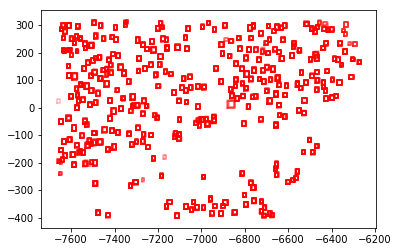

In [431]:

trs = trk_mat

#for c in range(0,trs.shape[1]):
a1 = (512.*0.26 - trs[3,:]) - trs[5,:]
x1 = a1 + trs[0,:] 
b1 = trs[4,:]
y1 = b1 + trs[1,:] 

x2 = x1+(trs[5,:])
a2 = a1+(trs[5,:])
y2 = y1+(trs[6,:])
b2 = b1+(trs[6,:])

boolind = (a1/0.26 > 25) & (a2/0.26 < 487) & (b1/0.26 > 25) & (b2/0.26 < 487)

up = boolind
dn = (1-boolind).astype(np.bool)
print('mmm')
plot([x1[up],x2[up],x2[up],x1[up],x1[up]],[y1[up],y1[up],y2[up],y2[up],y1[up]],'-', c='r', alpha=0.3)
plot([x1[dn],x2[dn],x2[dn],x1[dn],x1[dn]],[y1[dn],y1[dn],y2[dn],y2[dn],y1[dn]],'-', c='g', alpha=0.3)

#ylim(0,300)
#xlim(-7700,-7400)


In [400]:
print(up.shape)
print(dn.shape)
print(trk_mat.shape)

(9, 5257)
(9, 3009)
(9, 8266)


In [397]:
1-boolind

array([1, 0, 1, ..., 0, 0, 0])

In [398]:
boolind

array([False,  True, False, ...,  True,  True,  True])

(-7740.3, -6193.7, -442.35, 357.35)

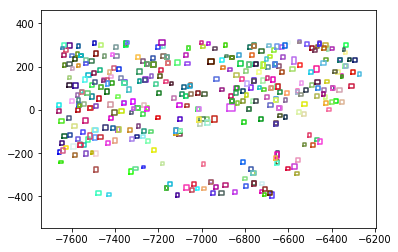

In [408]:
for d in out_out:
    d = d.astype(np.int32)
    #print(d)
    random.seed( d[4] )
    R = (random.random())  # same random number as before
    G = (random.random())  # same random number as before
    B = (random.random()) # same random number as before
    plot([d[0],d[2],d[2],d[0],d[0]],[d[1],d[1],d[3],d[3],d[1]],'-',c=[R,G,B])
plt.axis('equal')
#plt.xlim(x0,x1)
#plt.ylim(y0,y1)

In [ ]:

#plt.xlim(x0,x1)
#plt.ylim(y0,y1)
for d in in_results:
    d = d.astype(np.int32)
    #print(d)
    if d[0] > x0 and d[0] < x1:
        if d[1] > y0 and d[1] < y1:
            plot([d[0],d[2],d[2],d[0],d[0]],[d[1],d[1],d[3],d[3],d[1]],'r-')
plt.axis('equal')

ValueError: Unrecognized character 0 in format string

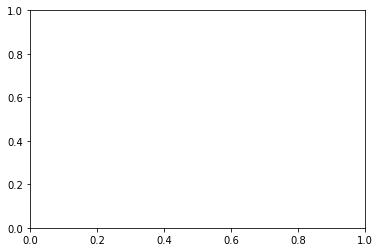

In [177]:
for d in out_results:
    d = d.astype(np.int32)
    #print(d)
    #if d[0] > x0 and d[0] < x1:
    #    if d[1] > y0 and d[1] < y1:
    plot([d[0],d[2],d[2],d[0],d[0]],[d[1],d[1],d[3],d[3],d[1]],'0')


In [ ]:


xa0 = 5
xa1 = 7
ya0 = 6
ya1 = 8

xb0 = 6
xb1 = 7
yb0 = 6
yb1 = 8
plot([xa0,xa1,xa1,xa0,xa0],[ya0,ya0,ya1,ya1,ya0],'r-')
plot([xb0,xb1,xb1,xb0,xb0],[yb0,yb0,yb1,yb1,yb0],'b-')
GT = [xa0,ya0,xa1,ya1]
test = [xb0,yb0,xb1,yb1]
print(overlap(test,GT))

In [ ]:
#Visualise avialable regions.
plot(trk_mat[0,:],trk_mat[1,:],'o')

In [ ]:
import cv2
img = cv2.imread('/Users/dwaithe/Desktop/out.tif')
x0 = -3266.7
x1 = -1866.7
y0 = 1291.7
y1 = 2291.7

figsize(12,12)
#imshow(img)
minx = np.min(trk_mat[0,:])
miny = np.min(trk_mat[1,:])
for d in out_results:
    d = d.astype(np.int32)
    #print(d)
    
    if d[0] > x0 and d[0] < x1:
        if d[1] > y0 and d[1] < y1:
            d[0] = (d[0]-minx)/0.26
            d[2] = (d[2]-minx)/0.26
            d[1] = (d[1]-miny)/0.26
            d[3] = (d[3]-miny)/0.26
            random.seed( d[4] )
            R = (random.random())  # same random number as before
            G = (random.random())  # same random number as before
            B = (random.random()) # same random number as before
            plot([d[0],d[2],d[2],d[0],d[0]],[d[1],d[1],d[3],d[3],d[1]],c=[R,G,B])
plt.axis('equal')
#plt.xlim(0,1000)
#plt.ylim(2300,3800)

In [ ]:
coord

In [ ]:
#Now we search raw entries.
#ent = random.choice(list(coord.keys()))
ent = random.choice(list(coord.keys()))
sent = coord[ent]
out_list = []
#Go through list of coordinates:
for c in range(0,trk_mat.shape[1]):
    #Extract track
    trk = trk_mat[:,c]
    #Corresponding entries in grid.
    for se in sent:
        x,y = se.split('_')
        #print(x,y)
        if float(x) == trk[0] and float(y) == trk[1]:
            out_list.append(c)

            
for ent in coord:
    #print(coord[ent].__len__())
    x,y = ent.split('_')
    plot(float(x),float(y),'ro')
plt.axis('equal')


for se in sent:
    #print( sent)
    x0,y0 = se.split('_')
    

    plot(x0,y0,'bo')
trks = trk_mat[:,np.array(out_list)]

for c in range(0,trks.shape[1]):
    trk = trks[:,c]
    a = trk[3]+trk[0]
    b = trk[3]+trk[5]+trk[0]
    c = trk[4]+trk[1]
    d = trk[4]+trk[6]+trk[1]
    plot([a,b,b,a,a],[c,c,d,d,c],'g-')

In [ ]:
trks = trk_mat#[:,np.array(out_list)]

for c in range(0,trks.shape[1]):
    trk = trks[:,c]
    a = trk[3]+trk[0]
    b = trk[3]+trk[5]+trk[0]
    c = trk[4]+trk[1]
    d = trk[4]+trk[6]+trk[1]
    plot([a,b,b,a,a],[c,c,d,d,c])
    

In [ ]:
#Select random option
ent = random.choice(list(coord.keys()))
sent = coord[ent]

##                        |
##PLOT all the data here.\/
##
a = trk_mat[0,:]+trk_mat[3,:]
b = trk_mat[0,:]+trk_mat[3,:]+trk_mat[5,:]
c = trk_mat[1,:]+trk_mat[4,:]
d = trk_mat[1,:]+trk_mat[4,:]+trk_mat[6,:]
#plot([a,b,b,a,a], [c,c,d,d,c],'r-');
plt.axis('equal')
##                       /\
##PLOT all the data here.|
##



##                         |
##PLOT the locations here.\/
##
for ent in coord:
    #print(coord[ent].__len__())
    x,y = ent.split('_')
    #plot(float(x),float(y),'ro')
plt.axis('equal')
for se in sent:
    #print( sent)
    x0,y0 = se.split('_')
    #plot(x0,y0,'bo')
##                        /\
##PLOT the locations here.|
##
    
##                              |
##Find the nearby regions here.\/
##    
out_list = []
#Go through list of coordinates:
for c in range(0,trk_mat.shape[1]):
    #Extract track
    trk = trk_mat[:,c]
    #Corresponding entries in grid.
    for se in sent:
        x,y = se.split('_')
        #print(x,y)
        if float(x) == trk[0] and float(y) == trk[1]:
            out_list.append(c)
trks = trk_mat[:,np.array(out_list)]  
##                              |
##Plot the nearby regions here.\/
##   
for c in range(0,trks.shape[1]):
    trk = trks[:,c]
    a = trk[3]+trk[0]
    b = trk[3]+trk[5]+trk[0]
    c = trk[4]+trk[1]
    d = trk[4]+trk[6]+trk[1]
    #plot([a,b,b,a,a],[c,c,d,d,c],'g-',alpha=0.5)